Overview: Fit
-------------

**PyAutoLens** uses `Tracer` objects to represent a strong lensing system. Now, we`re going use these objects to
fit `Imaging` data of a strong lens.

The autolens_workspace comes distributed with simulated images of strong lenses (an example of how these simulations
are made can be found in the `simulate.py` example, with all simulator scripts located in `autolens_workspac/simulators`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


We we begin by loading the strong lens dataset `mass_sie__source_sersic` `from .fits files:

Load the strong lens dataset `light_sersic__mass_sie__source_sersic` `from .fits files, which is the dataset 
we will use to demosntrate fitting.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

We can use the `Imaging` mat_plot_2d to plot the image, noise-map and psf of the dataset.

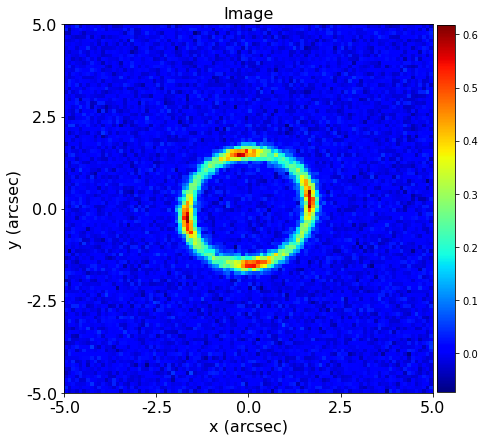

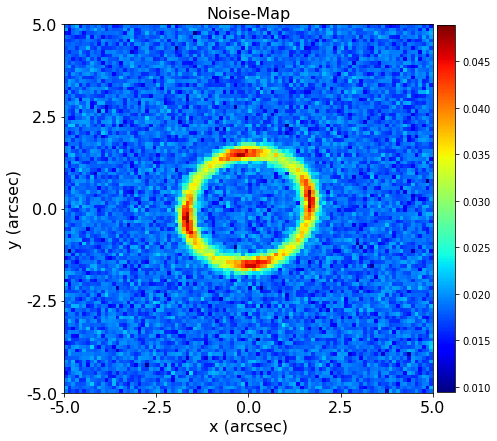

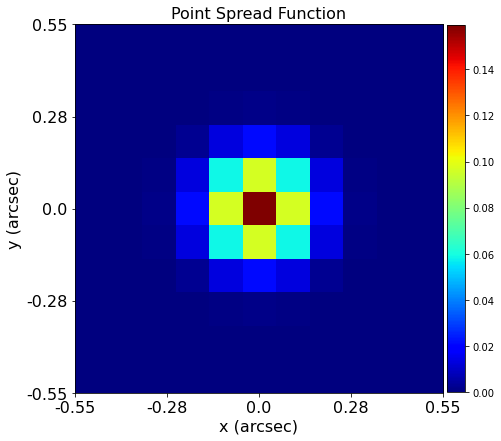

In [3]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True, noise_map=True, psf=True)

The `Imaging` mat_plot_2d also contains a subplot which plots all these properties simultaneously.

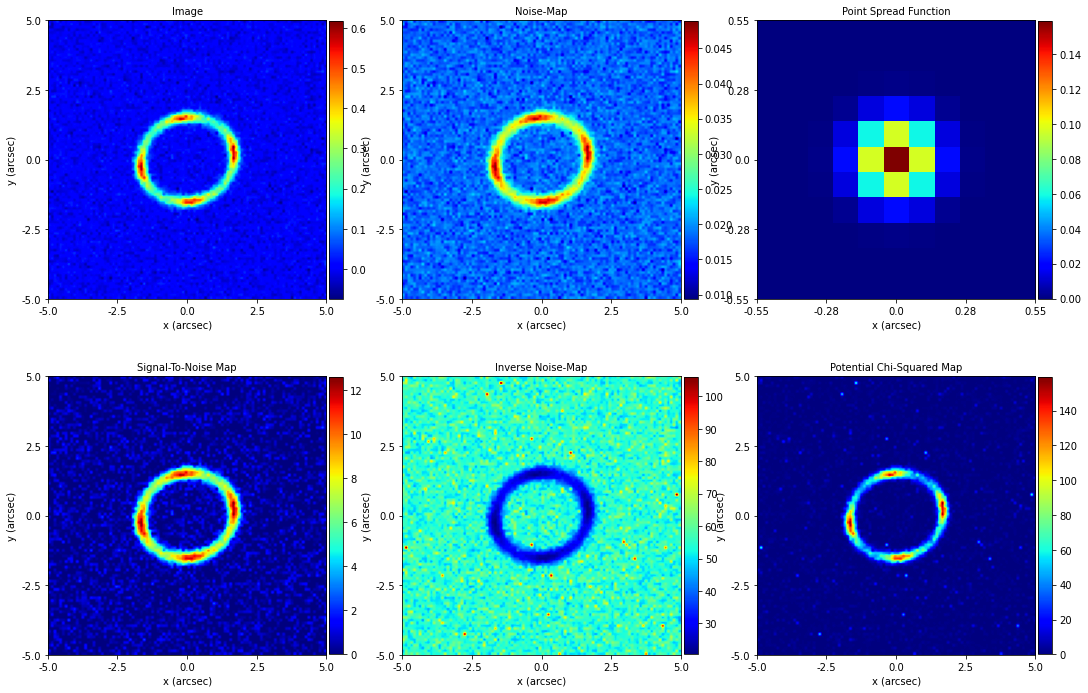

In [4]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

We now need to mask the data, so that regions where there is no signal (e.g. the edges) are omitted from the fit.

In [5]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    radius=3.0,
)

The MaskedImaging object combines the dataset with the mask.
 
Here, the Mask2D is also used to compute the `Grid2D` we used in the lensing.py tutorial to compute lensing calculations.
Note how the Grid2D has also had the mask applied to it.

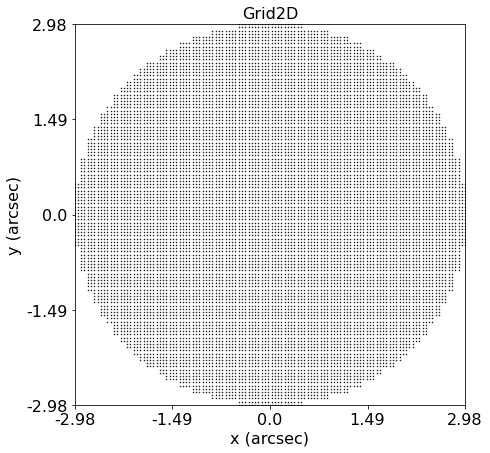

In [6]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

grid_plotter = aplt.Grid2DPlotter(grid=masked_imaging.grid)
grid_plotter.figure()

Here is what our image looks like with the mask applied, where PyAutoLens has automatically zoomed around the mask
to make the lensed source appear bigger.

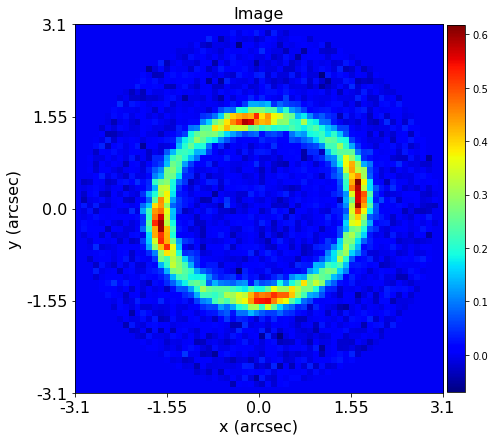

In [7]:
imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging)
imaging_plotter.figures(image=True)

Following the lensing.py example, we can make a tracer from a collection of `LightProfile`, `MassProfile` and `Galaxy`
objects.

The combination of `LightProfile`'s and `MassProfile`'s below is the same as those used to generate the lensed data-set,
thus it produces a tracer whose image looks exactly like the dataset. As discussed in the lensing.py tutorial, this
tracer can be extended to include additional `LightProfile`'s`s, `MassProfile`'s and `Galaxy``s, for example if you 
wanted to fit a tracer where the lens light is included.

In [8]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Following the lensing.py example, we can make a tracer from a collection of `LightProfile`, `MassProfile` and `Galaxy`
objects. We can then use the `FitImaging` object to fit this tracer to the dataset. 

The fit performs the necessary tasks to create the model image we fit the data with, such as blurring the tracer`s 
image with the `Imaging` PSF. We can see this by comparing the tracer`s image (which isn't PSF convolved) and the 
fit`s model image (which is).

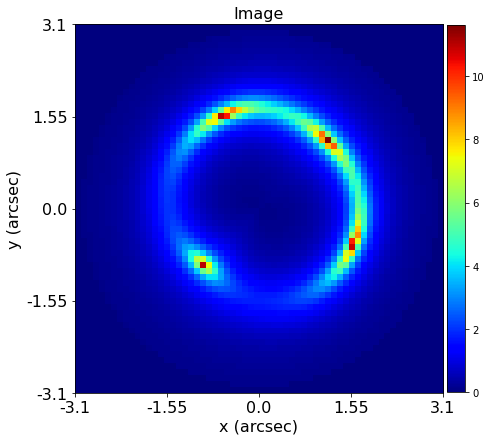

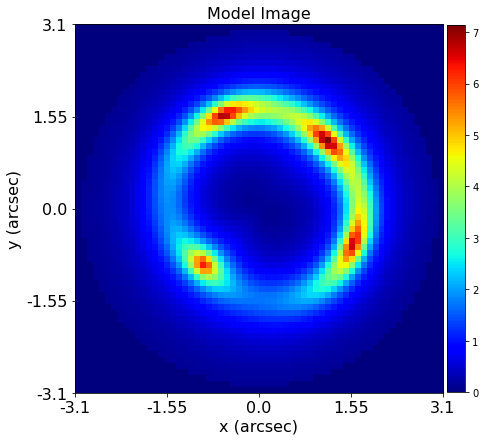

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=masked_imaging.grid)
tracer_plotter.figures(image=True)

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.figures(model_image=True)

The fit creates the following:

 - The residual-map: The model-image subtracted from the observed dataset`s image.
 - The normalized residual-map: The residual-map divided by the noise-map.
 - The chi-squared-map: The normalized residual-map squared.

we'll plot all 3 of these, alongside a subplot containing them all.

For a good lens model where the model image and tracer are representative of the strong lens system the
residuals, normalized residuals and chi-squareds are minimized:

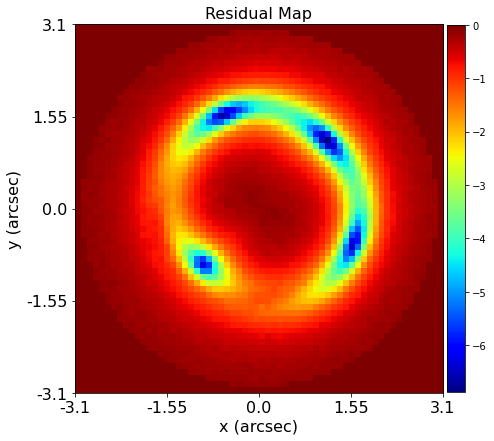

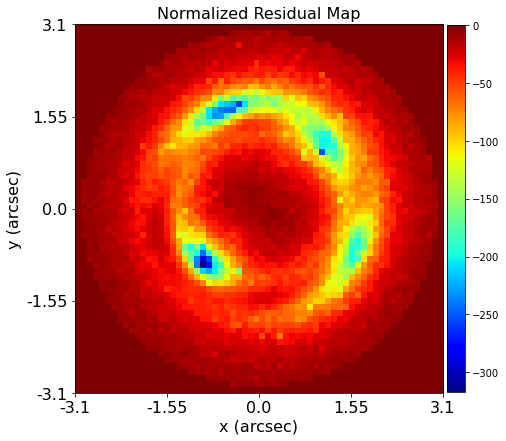

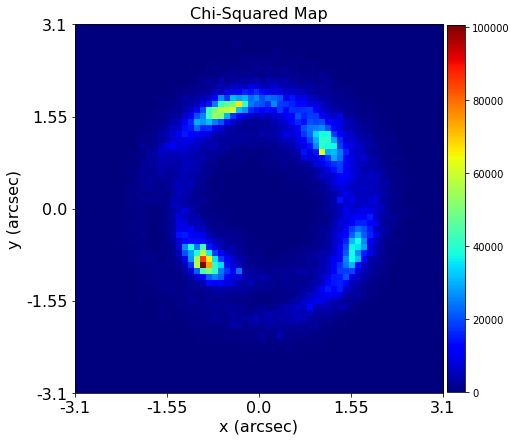

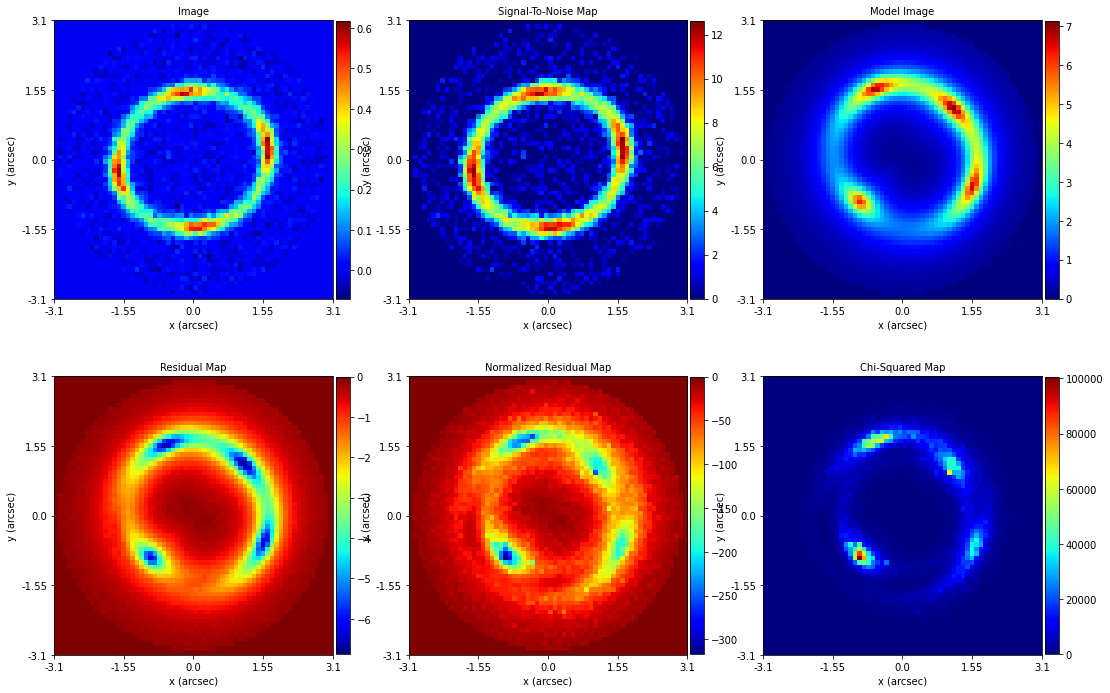

In [10]:
fit_imaging_plotter.figures(
    residual_map=True, normalized_residual_map=True, chi_squared_map=True
)
fit_imaging_plotter.subplot_fit_imaging()

In contrast, a bad lens model will show features in the residual-map and chi-squareds.

We can produce such an image by creating a tracer with different lens and source galaxies. In the example below, we 
change the centre of the source galaxy from (0.1, 0.1) to (0.12, 0.12), which leads to residuals appearing
in the fit.

In [11]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.12, 0.12),
        elliptical_comps=(0.0, 0.111111),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets create a new fit using this tracer and replot its residuals, normalized residuals and chi-squareds.

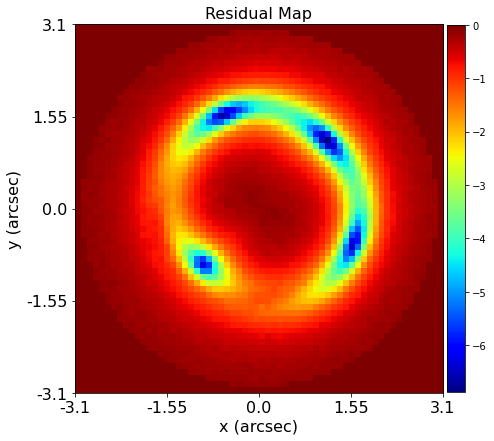

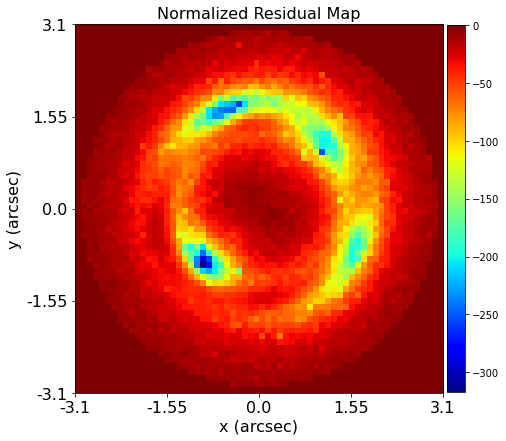

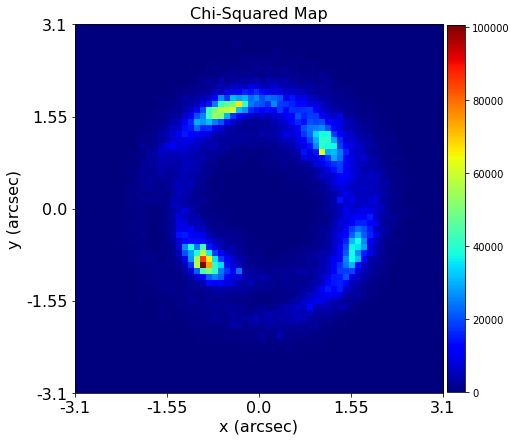

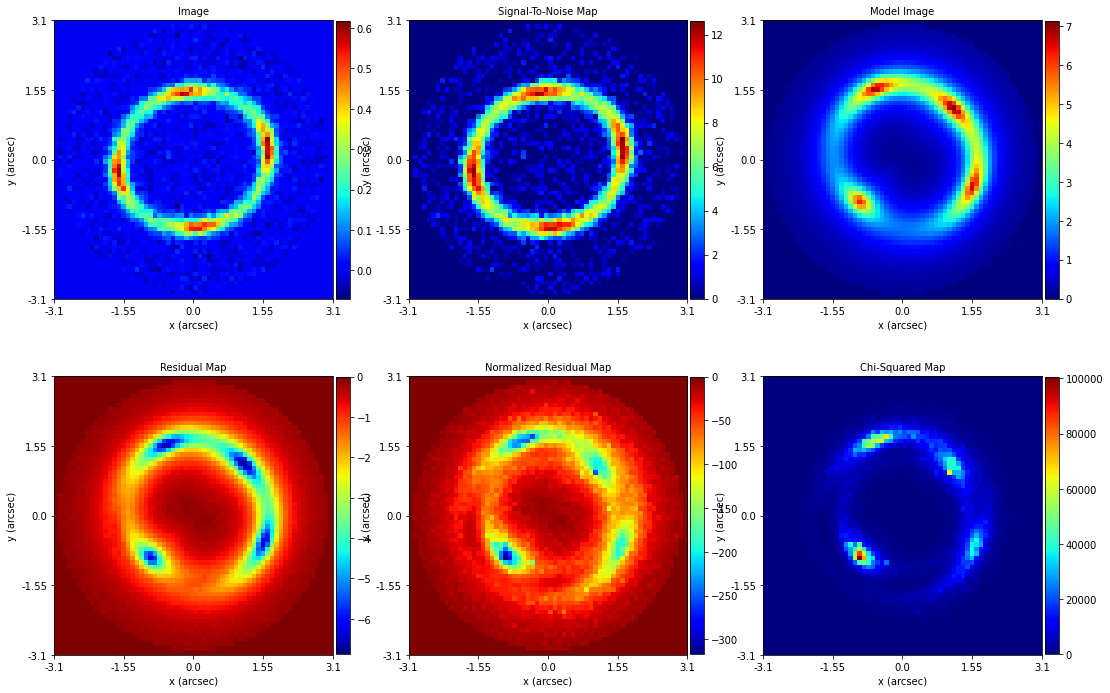

In [12]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter.figures(
    residual_map=True, normalized_residual_map=True, chi_squared_map=True
)
fit_imaging_plotter.subplot_fit_imaging()

Finish.